# Dimensionality Reduction Evaluation
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate dimensionality reduction techniques for their ability to preserve Euclidean structure of high-dimensional datasets.__  
  
To benchmark these techniques, we are using two single-cell RNAseq datasets:
* From [__Macosko, *et al* (2015)__](https://www.ncbi.nlm.nih.gov/pubmed/26000488), the mouse retina scRNA-seq data generated using DropSeq: [GSM1626793](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM1626793)
* From [__Herring, *et al* (2018)__](https://www.ncbi.nlm.nih.gov/pubmed/29153838), the WT mouse colon scRNA-seq data generated using inDrops: [GSM2743164](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM2743164)  
  
The first set should be __discrete__, containing highly separable cell populations from the mouse retina, where the latter will be __continuous__, representing a continuum of branching cell states in the gut epithelium.  
  
Both datasets have been __preprocessed and feature-selected__ to allow for direct input to downstream dimensionality reduction algorithms (rather than first performing PCA to limit dimensional input). These methods are shown in [`dev/QC.ipynb`](dev/QC.ipynb) and [`dev/preprocess_and_filter.ipynb`](dev/preprocess_and_filter.ipynb).

In [116]:
from fcc_DRs import *
%matplotlib inline

In [45]:
# reload functions when editing file
del sys.modules['fcc_utils']
from fcc_utils import *

In [2]:
# read in Macosko retina data
retina = RNA_counts.from_file('inputs/GSM1626793_P14Retina_1.processed.tsv', cells_axis=0, labels=[0,0])
# read in Herring colon data
colon = RNA_counts.from_file('inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv', cells_axis=0, labels=[0,0])

In [3]:
# look at dimensions of counts matrix (cells, genes)
retina.data.shape

(1652, 500)

In [4]:
# look at dimensions of counts matrix (cells, genes)
colon.data.shape

(1653, 500)

---
### PCA
We'll look at principal component analysis (PCA) first, as a gold-standard. Because PCA performs a __linear__ transformation on the data, 500 PCs should perfectly preserve the overall dataset structure.

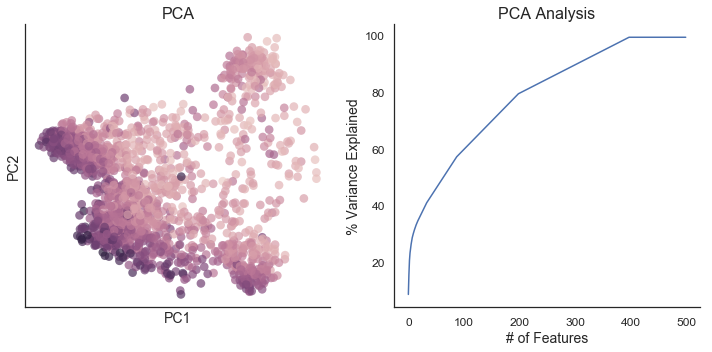

In [5]:
retina_PCA500 = fcc_PCA(retina.arcsinh_norm(), n_components=500)
retina_PCA500.plot_PCA()

We can test the Euclidean distance preservation as follows:

In [6]:
# choose value for K-nearest neighbor calculations. We use 30 because that is the standard perplexity chosen for DR techniques here.
k = 30

/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


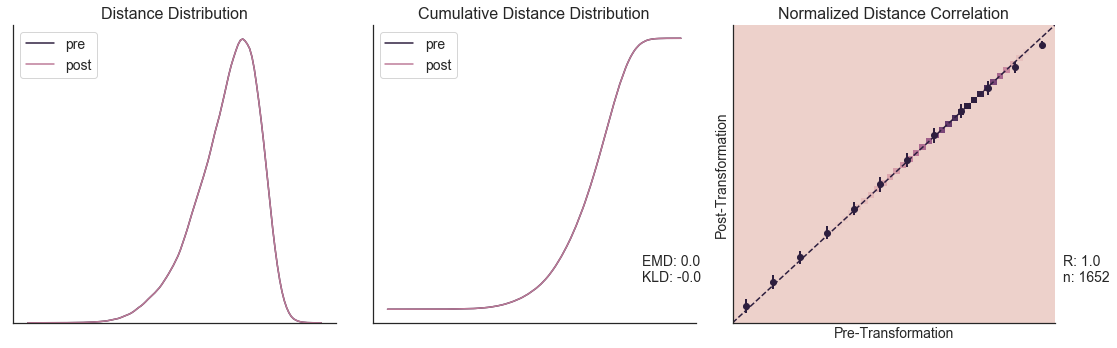

Knn Pres.: 100.0
CPU times: user 1min 30s, sys: 14.1 s, total: 1min 44s
Wall time: 1min 47s


In [11]:
%%time
mantel_stats, EMD, KLD = compare_euclid(pre=retina.distance_matrix(transform='arcsinh'), post=retina_PCA500.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_PCA500.knn_graph(k))
print('Knn Pres.: {}'.format(round(knn, 4)))

Now we can perform a PCA with a smaller number of components and determine the degree of information loss.  
The extreme example would be comparing only the __first two principal components__ to the original dataset:

In [12]:
# create dictionaries for dumping results into
final_distance_stats = {'Retina':{'R':{}, 'EMD':{}, 'KLD':{}, 'Knn Pres.':{}}, 'Colon':{'R':{}, 'EMD':{}, 'KLD':{}, 'Knn Pres.':{}}}

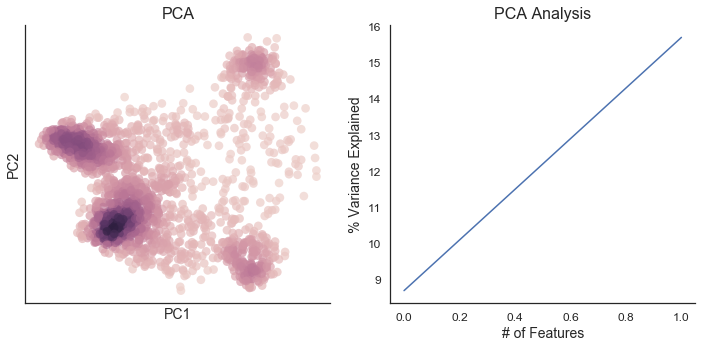

In [13]:
retina_PCA2 = fcc_PCA(retina.arcsinh_norm(), n_components=2)
retina_PCA2.plot_PCA()

R: 0.55
EMD: 0.3008
KLD: 0.168
Knn Pres.: 97.4598


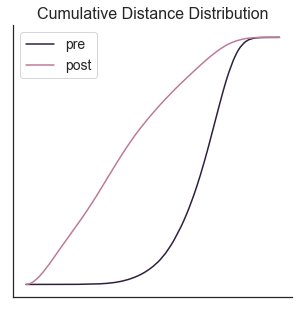

<Figure size 504x504 with 0 Axes>

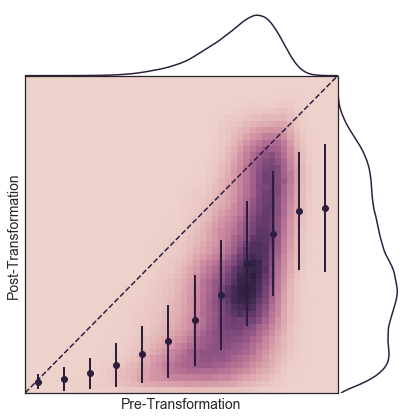

CPU times: user 1min 11s, sys: 10 s, total: 1min 21s
Wall time: 1min 23s


In [14]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_PCA2.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_PCA2.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['PCA (2)'], final_distance_stats['Retina']['EMD']['PCA (2)'], final_distance_stats['Retina']['KLD']['PCA (2)'], final_distance_stats['Retina']['Knn Pres.']['PCA (2)'] = mantel_stats[0], EMD, KLD, knn

CPU times: user 18.7 s, sys: 401 ms, total: 19.1 s
Wall time: 18.7 s


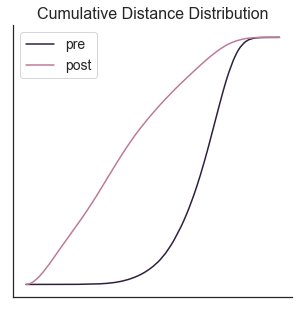

<Figure size 504x504 with 0 Axes>

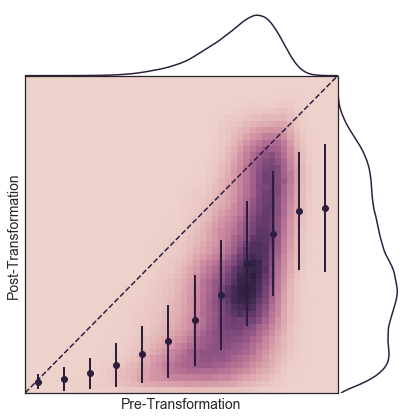

In [15]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_PCA2_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_PCA2_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

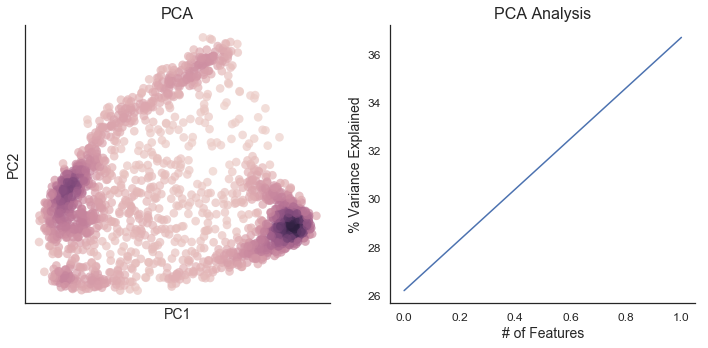

In [16]:
colon_PCA2 = fcc_PCA(colon.arcsinh_norm(), n_components=2)
colon_PCA2.plot_PCA()

In [17]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_PCA2.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_PCA2.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['PCA (2)'], final_distance_stats['Colon']['EMD']['PCA (2)'], final_distance_stats['Colon']['KLD']['PCA (2)'], final_distance_stats['Colon']['Knn Pres.']['PCA (2)'] = mantel_stats[0], EMD, KLD, knn

R: 0.7374
EMD: 0.0872
KLD: 0.1051
Knn Pres.: 97.8163
CPU times: user 1min 10s, sys: 11.7 s, total: 1min 22s
Wall time: 1min 25s


CPU times: user 20.6 s, sys: 573 ms, total: 21.2 s
Wall time: 21.7 s


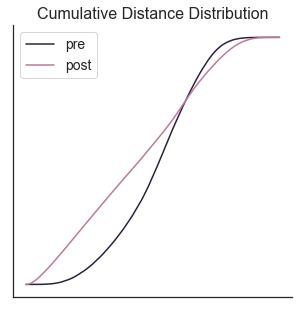

<Figure size 504x504 with 0 Axes>

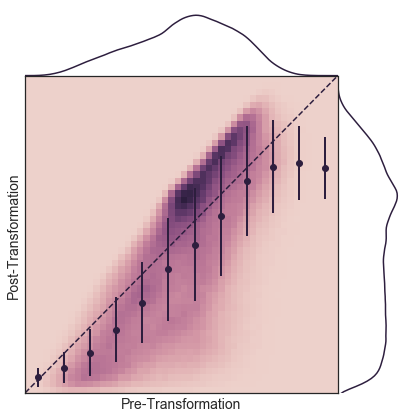

In [18]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_PCA2_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_PCA2_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# t-SNE
A workhorse technique for dimensionality reduction and visualization of scRNA-seq datasets, t-SNE performs a stochastic, non-linear transformation to project high-dimensional data into 2D in order to identify clustering and global structure.  
Here, we will plug arcsinh-normalized counts data directly into t-SNE and compare results to the original, feature-selected dataset.

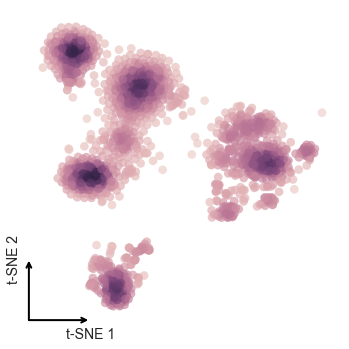

In [21]:
retina_tSNE = fcc_tSNE(retina.arcsinh_norm(), perplexity=30, seed=1)
retina_tSNE.plot()

In [103]:
np.savetxt(X=retina_tSNE.results, fname='dev/pymethods_out/retina_tSNE.csv', delimiter=',')

In [22]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_tSNE.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_tSNE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['t-SNE'], final_distance_stats['Retina']['EMD']['t-SNE'], final_distance_stats['Retina']['KLD']['t-SNE'], final_distance_stats['Retina']['Knn Pres.']['t-SNE'] = mantel_stats[0], EMD, KLD, knn

R: 0.5266
EMD: 0.2742
KLD: 0.1654
Knn Pres.: 97.294
CPU times: user 1min 7s, sys: 11.4 s, total: 1min 19s
Wall time: 1min 21s


CPU times: user 19.4 s, sys: 794 ms, total: 20.2 s
Wall time: 20.2 s


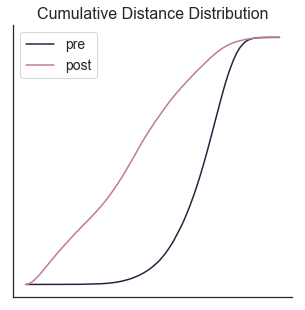

<Figure size 504x504 with 0 Axes>

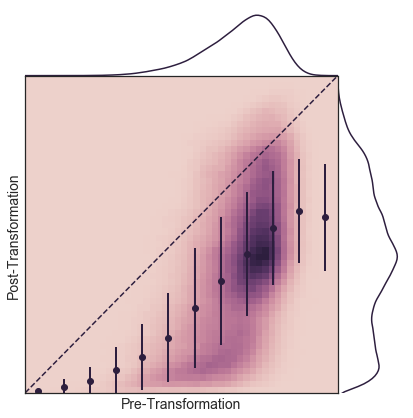

In [23]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_tSNE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_tSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

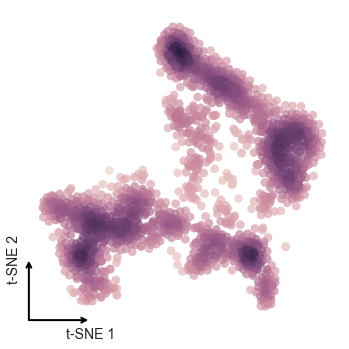

In [24]:
colon_tSNE = fcc_tSNE(colon.arcsinh_norm(), perplexity=30, seed=12)
colon_tSNE.plot()

In [104]:
np.savetxt(X=colon_tSNE.results, fname='dev/pymethods_out/colon_tSNE.csv', delimiter=',')

In [25]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_tSNE.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_tSNE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['t-SNE'], final_distance_stats['Colon']['EMD']['t-SNE'], final_distance_stats['Colon']['KLD']['t-SNE'], final_distance_stats['Colon']['Knn Pres.']['t-SNE'] = mantel_stats[0], EMD, KLD, knn

R: 0.7469
EMD: 0.1146
KLD: 0.0872
Knn Pres.: 97.6884
CPU times: user 1min 9s, sys: 12.3 s, total: 1min 21s
Wall time: 1min 25s


CPU times: user 20.9 s, sys: 511 ms, total: 21.4 s
Wall time: 22.7 s


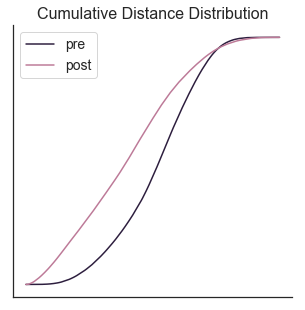

<Figure size 504x504 with 0 Axes>

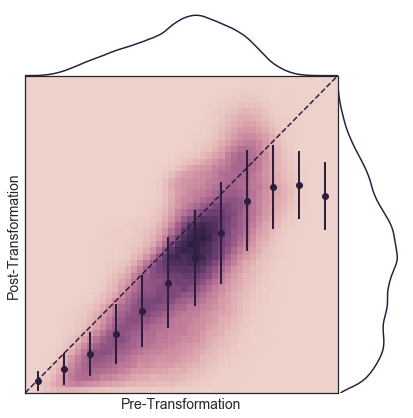

In [26]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_tSNE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_tSNE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# UMAP
Another popular method for low-dimensional projection of scRNA-seq datasets, UMAP creates high-dimensional manifolds that describe the structure of the dataset.  
Here, we will plug arcsinh-normalized counts data directly into UMAP and compare results to the original, feature-selected dataset.

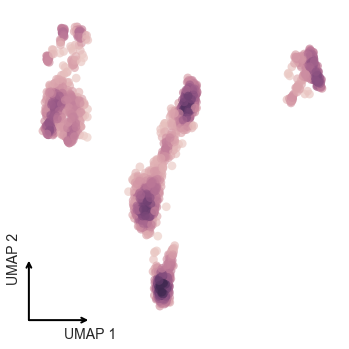

In [30]:
retina_UMAP = fcc_UMAP(retina.arcsinh_norm(), perplexity=30, seed=18)
retina_UMAP.plot()

In [105]:
np.savetxt(X=retina_UMAP.results, fname='dev/pymethods_out/retina_UMAP.csv', delimiter=',')

In [31]:
retina_UMAP.plot(save_to='images/retina_density_UMAP.png', figsize=(6,6))

In [32]:
retina_UMAP.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Opn1mw$')].flatten(), save_to='images/retina_Opn1mw_UMAP.png', figsize=(6,6))

In [33]:
retina_UMAP.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Rlbp1$')].flatten(), save_to='images/retina_Rlbp1_UMAP.png', figsize=(6,6))

In [34]:
retina_UMAP.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Pax6$')].flatten(), save_to='images/retina_Pax6_UMAP.png', figsize=(6,6))

In [35]:
retina_UMAP.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Vsx2$')].flatten(), save_to='images/retina_Vsx2_UMAP.png', figsize=(6,6))

In [36]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_UMAP.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_UMAP.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['UMAP'], final_distance_stats['Retina']['EMD']['UMAP'], final_distance_stats['Retina']['KLD']['UMAP'], final_distance_stats['Retina']['Knn Pres.']['UMAP'] = mantel_stats[0], EMD, KLD, knn

R: 0.5238
EMD: 0.3376
KLD: 0.2896
Knn Pres.: 97.1521
CPU times: user 1min 9s, sys: 12.4 s, total: 1min 21s
Wall time: 1min 27s


CPU times: user 19.7 s, sys: 657 ms, total: 20.4 s
Wall time: 20.2 s


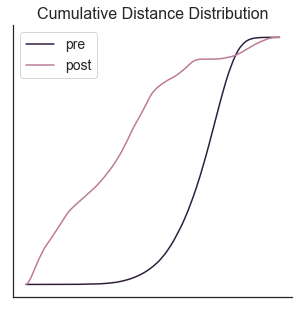

<Figure size 504x504 with 0 Axes>

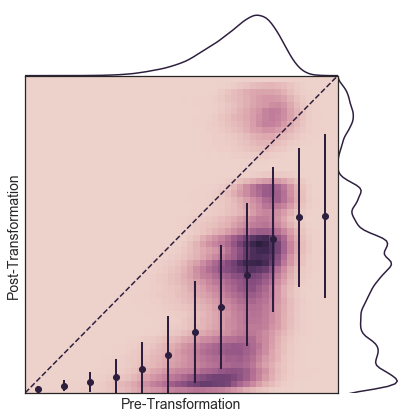

In [37]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_UMAP_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_UMAP_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

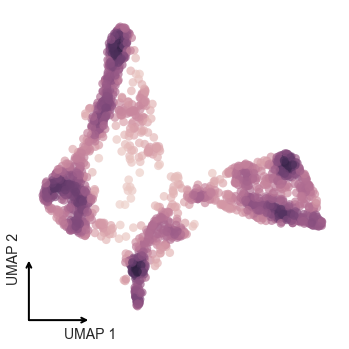

In [38]:
colon_UMAP = fcc_UMAP(colon.arcsinh_norm(), perplexity=30, seed=12)
colon_UMAP.plot()

In [106]:
np.savetxt(X=colon_UMAP.results, fname='dev/pymethods_out/colon_UMAP.csv', delimiter=',')

In [39]:
colon_UMAP.plot(save_to='images/colon_UMAP.png', figsize=(6,6))

In [40]:
colon_UMAP.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Muc2'].flatten(), save_to='images/colon_Muc2_UMAP.png', figsize=(6,6))

In [41]:
colon_UMAP.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Krt20'].flatten(), save_to='images/colon_Krt20_UMAP.png', figsize=(6,6))

In [42]:
colon_UMAP.plot(color=colon.arcsinh_norm()[:,colon.gene_IDs=='Reg4'].flatten(), save_to='images/colon_Reg4_UMAP.png', figsize=(6,6))

In [43]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_UMAP.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_UMAP.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['UMAP'], final_distance_stats['Colon']['EMD']['UMAP'], final_distance_stats['Colon']['KLD']['UMAP'], final_distance_stats['Colon']['Knn Pres.']['UMAP'] = mantel_stats[0], EMD, KLD, knn

R: 0.7215
EMD: 0.0977
KLD: 0.1119
Knn Pres.: 97.6149
CPU times: user 1min 9s, sys: 12.4 s, total: 1min 22s
Wall time: 1min 31s


CPU times: user 20.3 s, sys: 521 ms, total: 20.8 s
Wall time: 20.6 s


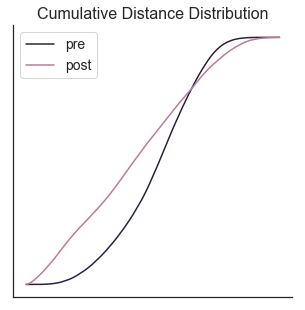

<Figure size 504x504 with 0 Axes>

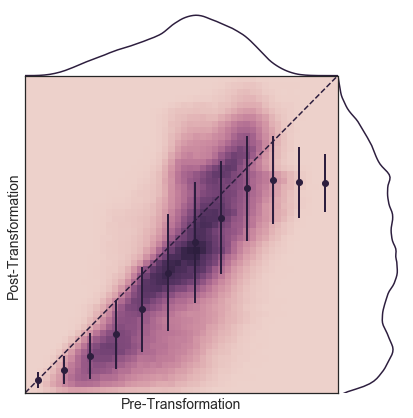

In [44]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_UMAP_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_UMAP_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# ZIFA
This method uses the zero-inflated negative binomial distribution to reduce RNA counts data to lower dimensions.  
Here, we will plug arcsinh-normalized counts data directly into ZIFA and compare results to the original, feature-selected dataset.

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 1652, D = 485, K = 2, n_blocks = 1
Block sizes [485]
Param change below threshold 1.000e-02 after 7 iterations


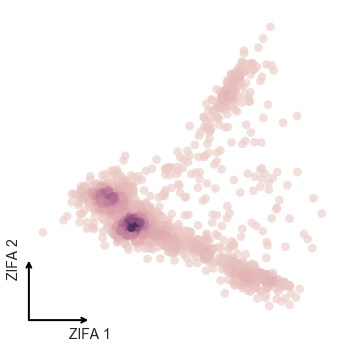

In [46]:
retina_ZIFA = fcc_ZIFA(retina.log2_norm(), K=2)
retina_ZIFA.plot()

In [107]:
np.savetxt(X=retina_ZIFA.results, fname='dev/pymethods_out/retina_ZIFA.csv', delimiter=',')

In [47]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='log2'), post=retina_ZIFA.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='log2'), post=retina_ZIFA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['ZIFA'], final_distance_stats['Retina']['EMD']['ZIFA'], final_distance_stats['Retina']['KLD']['ZIFA'], final_distance_stats['Retina']['Knn Pres.']['ZIFA'] = mantel_stats[0], EMD, KLD, knn

R: 0.4392
EMD: 0.1193
KLD: 0.2664
Knn Pres.: 96.8544
CPU times: user 1min 9s, sys: 11 s, total: 1min 20s
Wall time: 1min 21s


CPU times: user 18.2 s, sys: 422 ms, total: 18.6 s
Wall time: 18 s


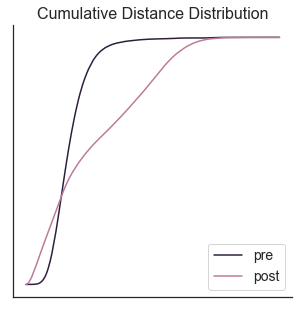

<Figure size 504x504 with 0 Axes>

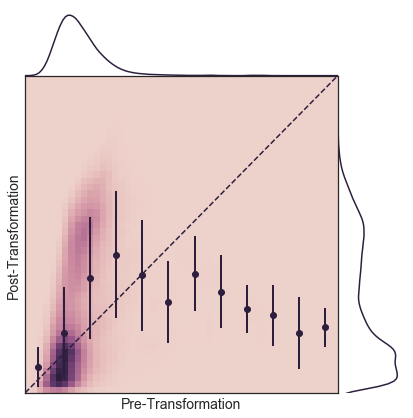

In [48]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_ZIFA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_ZIFA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 1653, D = 495, K = 2, n_blocks = 1
Block sizes [495]
Param change below threshold 1.000e-02 after 3 iterations


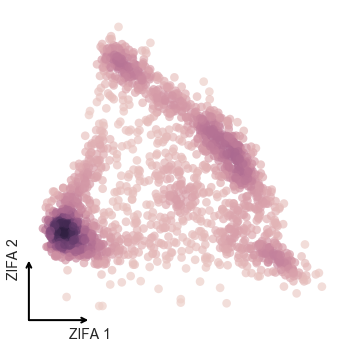

In [49]:
colon_ZIFA = fcc_ZIFA(colon.log2_norm(), K=2)
colon_ZIFA.plot()

In [108]:
np.savetxt(X=colon_ZIFA.results, fname='dev/pymethods_out/colon_ZIFA.csv', delimiter=',')

In [50]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='log2'), post=colon_ZIFA.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='log2'), post=colon_ZIFA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['ZIFA'], final_distance_stats['Colon']['EMD']['ZIFA'], final_distance_stats['Colon']['KLD']['ZIFA'], final_distance_stats['Colon']['Knn Pres.']['ZIFA'] = mantel_stats[0], EMD, KLD, knn

R: 0.5227
EMD: 0.111
KLD: 0.1463
Knn Pres.: 97.1328
CPU times: user 1min 16s, sys: 15 s, total: 1min 30s
Wall time: 1min 45s


CPU times: user 19.4 s, sys: 643 ms, total: 20 s
Wall time: 20.2 s


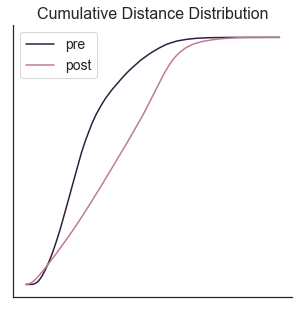

<Figure size 504x504 with 0 Axes>

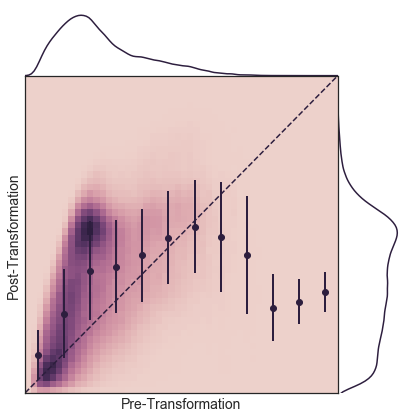

In [51]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_ZIFA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_ZIFA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# DCA
This method uses a deep count autoencoder to reduce RNA counts data to lower dimensions.  
Here, we will plug counts data directly into DCA and compare results to the original, feature-selected dataset.

In [52]:
%time retina_DCA = fcc_DCA(retina.counts, n_threads=4, norm=False)

DCA: Successfully preprocessed 500 genes and 1652 cells.
Instructions for updating:
Colocations handled automatically by placer.


2019-05-20 21:11:18,772 [WARNING] From /Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.


2019-05-20 21:11:19,916 [WARNING] From /Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 28.3 s, sys: 4.67 s, total: 33 s
Wall time: 15.7 s


In [109]:
np.savetxt(X=retina_DCA.results, fname='dev/pymethods_out/retina_DCA.csv', delimiter=',')

In [53]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_DCA.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_DCA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['DCA'], final_distance_stats['Retina']['EMD']['DCA'], final_distance_stats['Retina']['KLD']['DCA'], final_distance_stats['Retina']['Knn Pres.']['DCA'] = mantel_stats[0], EMD, KLD, knn

R: 0.9464
EMD: 0.0089
KLD: 0.0356
Knn Pres.: 97.8523
CPU times: user 1min 21s, sys: 13.9 s, total: 1min 35s
Wall time: 1min 38s


CPU times: user 17.9 s, sys: 398 ms, total: 18.3 s
Wall time: 18 s


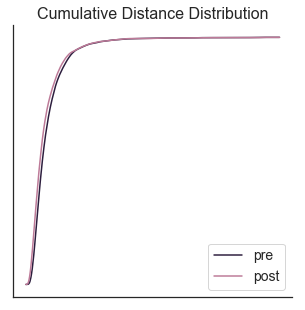

<Figure size 504x504 with 0 Axes>

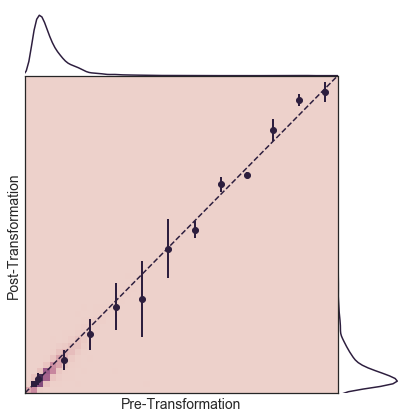

In [54]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_DCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_DCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [55]:
%time colon_DCA = fcc_DCA(colon.counts, n_threads=4, norm=False)

DCA: Successfully preprocessed 500 genes and 1653 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 53.3 s, sys: 8.83 s, total: 1min 2s
Wall time: 26.8 s


In [56]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_DCA.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_DCA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['DCA'], final_distance_stats['Colon']['EMD']['DCA'], final_distance_stats['Colon']['KLD']['DCA'], final_distance_stats['Colon']['Knn Pres.']['DCA'] = mantel_stats[0], EMD, KLD, knn

R: 0.9428
EMD: 0.0079
KLD: 0.0226
Knn Pres.: 98.2601
CPU times: user 1min 17s, sys: 13 s, total: 1min 30s
Wall time: 1min 31s


In [110]:
np.savetxt(X=colon_DCA.results, fname='dev/pymethods_out/colon_DCA.csv', delimiter=',')

CPU times: user 18.2 s, sys: 388 ms, total: 18.5 s
Wall time: 17.6 s


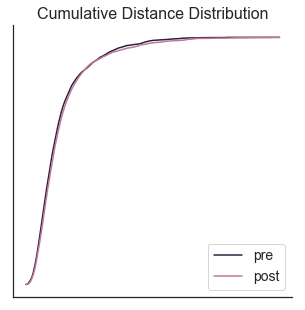

<Figure size 504x504 with 0 Axes>

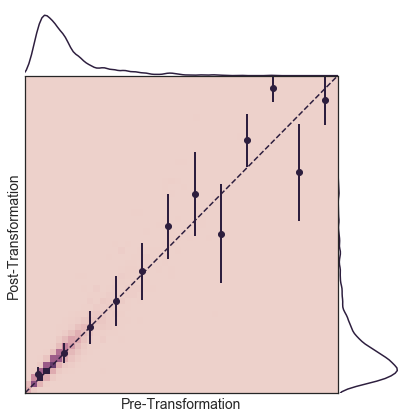

In [57]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_DCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_DCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# sc-VI
Here, we will plug counts data directly into sc-VI and compare results to the original, feature-selected dataset.

In [111]:
from scvi.dataset import CsvDataset, GeneExpressionDataset
import urllib
from scvi.models import *
from scvi.inference import UnsupervisedTrainer
use_batches=False

In [112]:
# Loading a local dataset into scVI
retina_scVI = CsvDataset('GSM1626793_P14Retina_1.processed.tsv', save_path='inputs/', new_n_genes=500, gene_by_cell=False, sep='\t')

File inputs/GSM1626793_P14Retina_1.processed.tsv already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [113]:
vae = VAE(retina_scVI.nb_genes, n_batch=retina_scVI.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              retina_scVI,
                              train_size=0.75,
                              use_cuda=True,
                              frequency=5)
trainer.train(n_epochs=400, lr=1e-3)

training: 100%|████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:38<00:00,  2.58it/s]


In [114]:
full = trainer.create_posterior(trainer.model, retina_scVI, indices=np.arange(len(retina_scVI)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

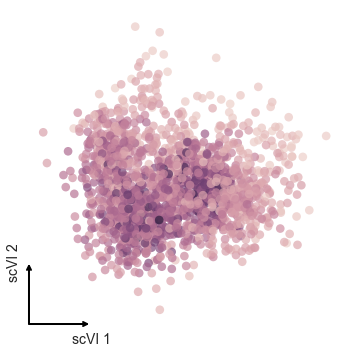

In [117]:
retina_scVI = DR(latent=latent.astype('double'), name='scVI')
retina_scVI.plot()

In [118]:
np.savetxt(X=retina_scVI.results, fname='dev/pymethods_out/retina_scVI.csv', delimiter=',')

In [119]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_scVI.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_scVI.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['scVI'], final_distance_stats['Retina']['EMD']['scVI'], final_distance_stats['Retina']['KLD']['scVI'], final_distance_stats['Retina']['Knn Pres.']['scVI'] = mantel_stats[0], EMD, KLD, knn

R: 0.1911
EMD: 0.3355
KLD: 0.2448
Knn Pres.: 96.8016
CPU times: user 1min 17s, sys: 13.1 s, total: 1min 30s
Wall time: 1min 40s


CPU times: user 19.2 s, sys: 529 ms, total: 19.7 s
Wall time: 19.5 s


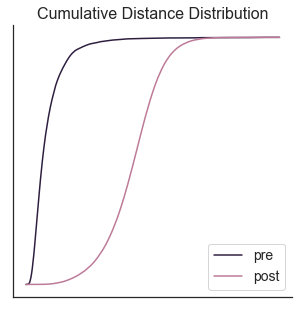

<Figure size 504x504 with 0 Axes>

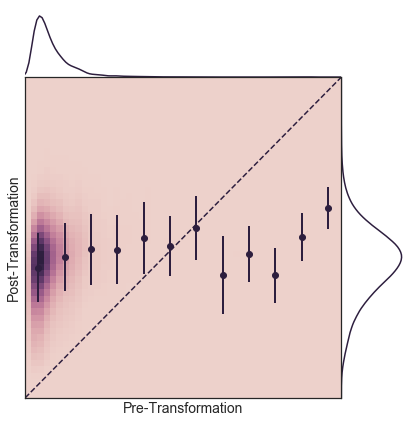

In [120]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_scVI_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_scVI_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [121]:
# Loading a local dataset into scVI
colon_scVI = CsvDataset('GSM2743164_rep1_colon_rnaseq.processed.tsv', save_path='inputs/', new_n_genes=500, gene_by_cell=False, sep='\t')

File inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv already downloaded
Preprocessing dataset
Finished preprocessing dataset


In [122]:
vae = VAE(colon_scVI.nb_genes, n_batch=colon_scVI.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              colon_scVI,
                              train_size=0.75,
                              use_cuda=True,
                              frequency=5)
trainer.train(n_epochs=400, lr=1e-3)

training: 100%|████████████████████████████████████████████████████████████████████████████████████| 400/400 [02:32<00:00,  2.75it/s]


In [123]:
full = trainer.create_posterior(trainer.model, colon_scVI, indices=np.arange(len(colon_scVI)))
latent, batch_indices, labels = full.sequential().get_latent()
batch_indices = batch_indices.ravel()

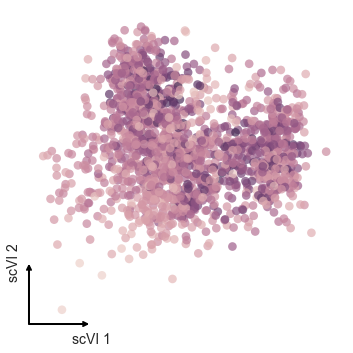

In [124]:
colon_scVI = DR(latent=latent.astype('double'), name='scVI')
colon_scVI.plot()

In [125]:
np.savetxt(X=colon_scVI.results, fname='dev/pymethods_out/colon_scVI.csv', delimiter=',')

In [126]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_scVI.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_scVI.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['scVI'], final_distance_stats['Colon']['EMD']['scVI'], final_distance_stats['Colon']['KLD']['scVI'], final_distance_stats['Colon']['Knn Pres.']['scVI'] = mantel_stats[0], EMD, KLD, knn

R: 0.2448
EMD: 0.2835
KLD: 0.2498
Knn Pres.: 97.0162
CPU times: user 1min 12s, sys: 10.9 s, total: 1min 23s
Wall time: 1min 25s


CPU times: user 21.2 s, sys: 530 ms, total: 21.7 s
Wall time: 21.9 s


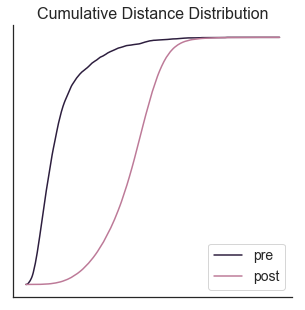

<Figure size 504x504 with 0 Axes>

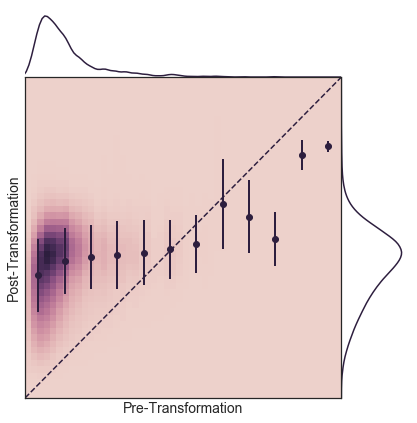

In [127]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_scVI_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_scVI_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# scvis
Here, we will plug counts data directly into scvis and compare results to the original, feature-selected dataset.

In [58]:
retina_scvis = DR.from_file(datafile='dev/scvis_out/retina/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv',
                            name='scvis')

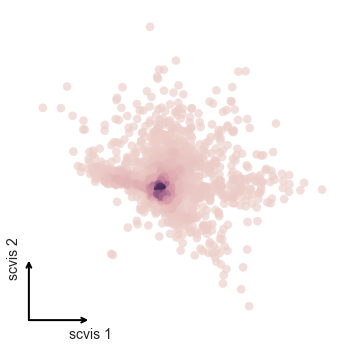

In [59]:
retina_scvis.plot()

In [60]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_scvis.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_scvis.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['scvis'], final_distance_stats['Retina']['EMD']['scvis'], final_distance_stats['Retina']['KLD']['scvis'], final_distance_stats['Retina']['Knn Pres.']['scvis'] = mantel_stats[0], EMD, KLD, knn

R: 0.7885
EMD: 0.0685
KLD: 0.0771
Knn Pres.: 97.8984
CPU times: user 1min 10s, sys: 12 s, total: 1min 22s
Wall time: 1min 23s


CPU times: user 18.5 s, sys: 449 ms, total: 19 s
Wall time: 18.4 s


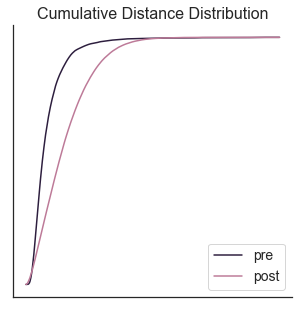

<Figure size 504x504 with 0 Axes>

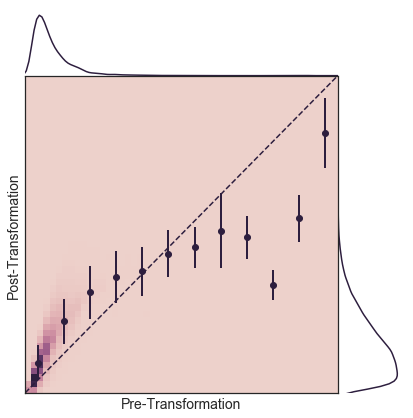

In [61]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_scvis_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_scvis_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [62]:
colon_scvis = DR.from_file(datafile='dev/scvis_out/colon/perplexity_30_regularizer_0.001_batch_size_512_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.tsv',
                            name='scvis')

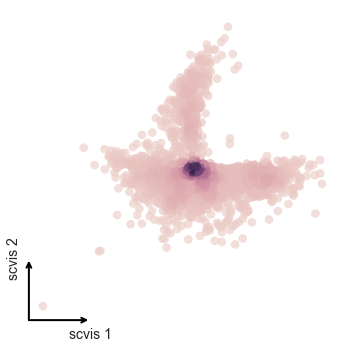

In [63]:
colon_scvis.plot()

In [64]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_scvis.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_scvis.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['scvis'], final_distance_stats['Colon']['EMD']['scvis'], final_distance_stats['Colon']['KLD']['scvis'], final_distance_stats['Colon']['Knn Pres.']['scvis'] = mantel_stats[0], EMD, KLD, knn

R: 0.787
EMD: 0.0595
KLD: 0.0825
Knn Pres.: 98.5684
CPU times: user 1min 10s, sys: 12.2 s, total: 1min 23s
Wall time: 1min 23s


CPU times: user 18.7 s, sys: 460 ms, total: 19.1 s
Wall time: 18.7 s


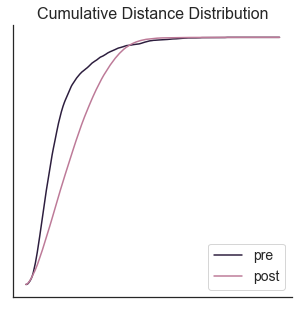

<Figure size 504x504 with 0 Axes>

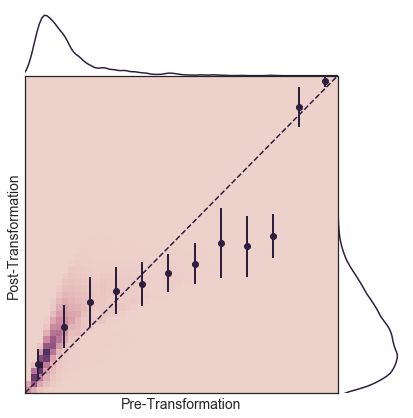

In [65]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_scvis_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_scvis_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
# SIMLR
This method builds cell-cell similarity matrices to predict cluster number and assign cells to clusters based on similarity.
First, read in the `F` construct that consists of a c-dimensional output of length `n_cells`, where c is the number of expected clusters passed to SIMLR.  
Here, c was estimated using the `SIMLR_Estimate_Number_of_Clusters` function from the SIMLR package.

In [128]:
retina_SIMLR = DR.from_file('dev/Rmethods_out/retina_SIMLR_F.csv', name='SIMLR', labels=[None,0]) # read in low-dim space for comparison
retina_SIMLR_2D = DR.from_file('dev/Rmethods_out/retina_SIMLR_ydata.csv', name='SIMLR', labels=[None,0]) # read in 2D projection for visualization

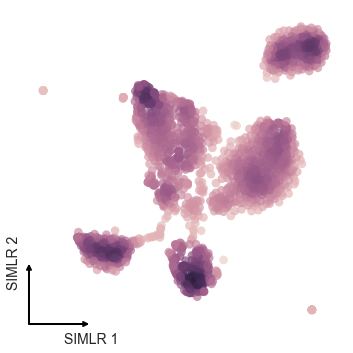

In [129]:
retina_SIMLR_2D.plot()

In [130]:
retina_SIMLR_2D.plot(save_to='retina_SIMLR.png')

In [131]:
retina_SIMLR_2D.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Rlbp1$')].flatten(), save_to='retina_Rlbp1_SIMLR.png')

In [132]:
retina_SIMLR_2D.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Pax6$')].flatten(), save_to='retina_Pax6_SIMLR.png')

In [133]:
retina_SIMLR_2D.plot(color=retina.arcsinh_norm()[:,retina.gene_IDs.str.contains('Opn1mw$')].flatten(), save_to='retina_Opn1mw_SIMLR.png')

In [134]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform='arcsinh'), post=retina_SIMLR.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform='arcsinh'), post=retina_SIMLR.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['SIMLR'], final_distance_stats['Retina']['EMD']['SIMLR'], final_distance_stats['Retina']['KLD']['SIMLR'], final_distance_stats['Retina']['Knn Pres.']['SIMLR'] = mantel_stats[0], EMD, KLD, knn

R: 0.2669
EMD: 0.1994
KLD: 0.1461
Knn Pres.: 97.8925
CPU times: user 1min 7s, sys: 8.98 s, total: 1min 16s
Wall time: 1min 17s


CPU times: user 18.8 s, sys: 376 ms, total: 19.1 s
Wall time: 18.4 s


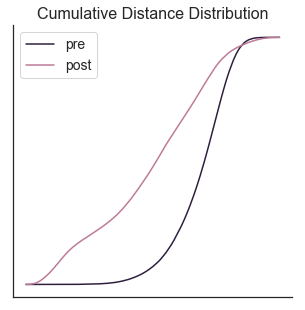

<Figure size 504x504 with 0 Axes>

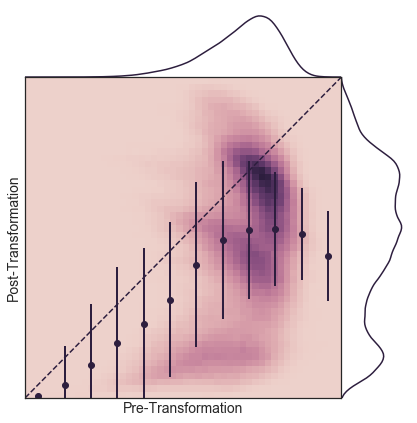

In [135]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_SIMLR_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_SIMLR_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [136]:
colon_SIMLR = DR.from_file('dev/Rmethods_out/colon_SIMLR_F.csv', name='SIMLR', labels=[None,0]) # read in low-dim space for comparison
colon_SIMLR_2D = DR.from_file('dev/Rmethods_out/colon_SIMLR_ydata.csv', name='SIMLR', labels=[None,0]) # read in 2D projection for visualization

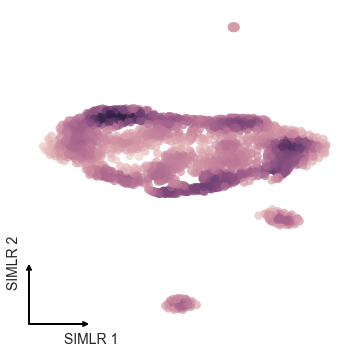

In [137]:
colon_SIMLR_2D.plot()

In [138]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform='arcsinh'), post=colon_SIMLR.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform='arcsinh'), post=colon_SIMLR.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['SIMLR'], final_distance_stats['Colon']['EMD']['SIMLR'], final_distance_stats['Colon']['KLD']['SIMLR'], final_distance_stats['Colon']['Knn Pres.']['SIMLR'] = mantel_stats[0], EMD, KLD, knn

R: 0.6915
EMD: 0.1424
KLD: 0.0721
Knn Pres.: 97.7478
CPU times: user 1min 10s, sys: 8.99 s, total: 1min 19s
Wall time: 1min 19s


CPU times: user 18.8 s, sys: 363 ms, total: 19.2 s
Wall time: 18.4 s


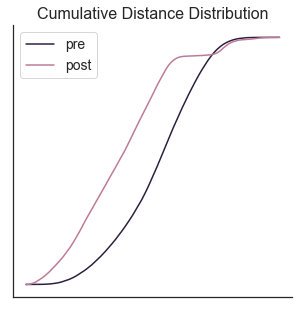

<Figure size 504x504 with 0 Axes>

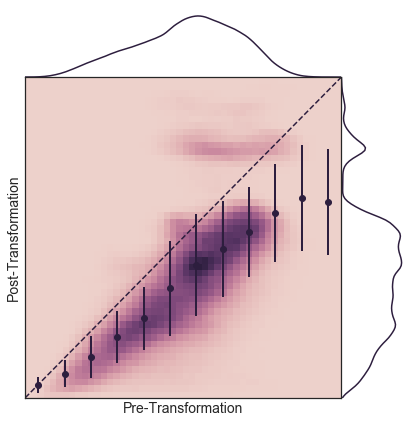

In [139]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_SIMLR_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_SIMLR_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
### ZINB-WAVE

In [140]:
retina_ZINBWAVE = DR.from_file('dev/Rmethods_out/retina_ZINB-WAVE.csv', name='ZINB-WaVE', labels=[None,0])

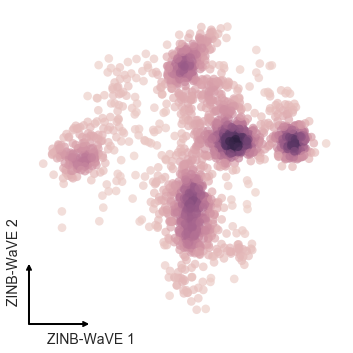

In [141]:
retina_ZINBWAVE.plot()

In [142]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_ZINBWAVE.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_ZINBWAVE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['ZINB-WaVE'], final_distance_stats['Retina']['EMD']['ZINB-WaVE'], final_distance_stats['Retina']['KLD']['ZINB-WaVE'], final_distance_stats['Retina']['Knn Pres.']['ZINB-WaVE'] = mantel_stats[0], EMD, KLD, knn

R: 0.2146
EMD: 0.2625
KLD: 0.3343
Knn Pres.: 96.7389
CPU times: user 1min 7s, sys: 9.92 s, total: 1min 17s
Wall time: 1min 17s


CPU times: user 18.8 s, sys: 460 ms, total: 19.3 s
Wall time: 18.7 s


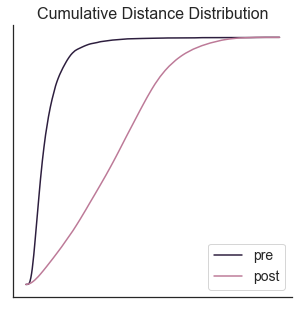

<Figure size 504x504 with 0 Axes>

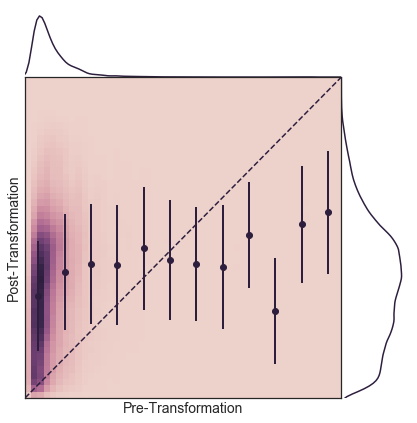

In [143]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_ZINB-WaVE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_ZINB-WaVE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [144]:
colon_ZINBWAVE = DR.from_file('dev/Rmethods_out/colon_ZINB-WAVE.csv', name='ZINB-WaVE', labels=[None,0])

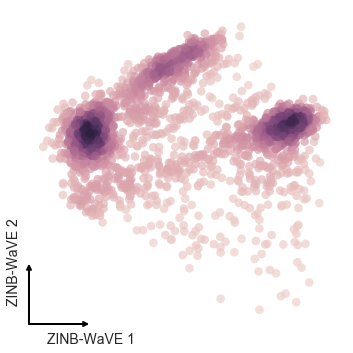

In [145]:
colon_ZINBWAVE.plot()

In [146]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_ZINBWAVE.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_ZINBWAVE.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['ZINB-WaVE'], final_distance_stats['Colon']['EMD']['ZINB-WaVE'], final_distance_stats['Colon']['KLD']['ZINB-WaVE'], final_distance_stats['Colon']['Knn Pres.']['ZINB-WaVE'] = mantel_stats[0], EMD, KLD, knn

R: 0.2244
EMD: 0.2304
KLD: 0.3283
Knn Pres.: 96.9483
CPU times: user 1min 8s, sys: 10.6 s, total: 1min 18s
Wall time: 1min 19s


CPU times: user 18.4 s, sys: 392 ms, total: 18.8 s
Wall time: 18 s


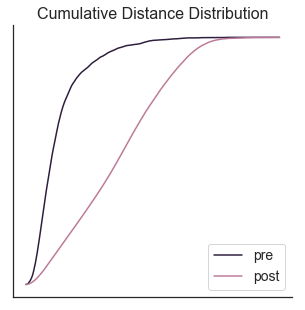

<Figure size 504x504 with 0 Axes>

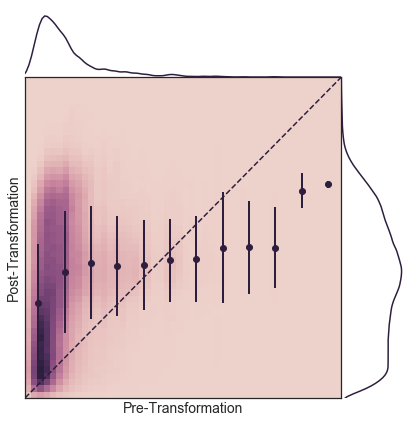

In [147]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_ZINB-WaVE_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_ZINB-WaVE_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
### GLM-PCA

In [148]:
retina_GLMPCA = DR.from_file('dev/Rmethods_out/retina_GLM-PCA.csv', name='GLM-PC', labels=[None,0])

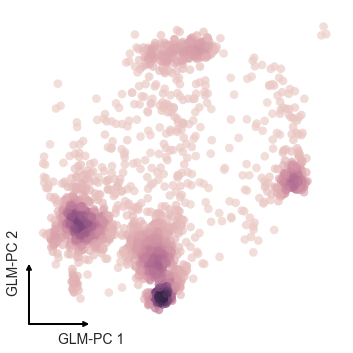

In [149]:
retina_GLMPCA.plot()

In [150]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=retina.distance_matrix(transform=None), post=retina_GLMPCA.distance_matrix())
knn = knn_preservation(pre=retina.knn_graph(k, transform=None), post=retina_GLMPCA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Retina']['R']['GLM-PCA'], final_distance_stats['Retina']['EMD']['GLM-PCA'], final_distance_stats['Retina']['KLD']['GLM-PCA'], final_distance_stats['Retina']['Knn Pres.']['GLM-PCA'] = mantel_stats[0], EMD, KLD, knn

R: 0.1767
EMD: 0.2333
KLD: 0.4096
Knn Pres.: 96.7375
CPU times: user 1min 8s, sys: 10.7 s, total: 1min 18s
Wall time: 1min 20s


CPU times: user 19.1 s, sys: 502 ms, total: 19.6 s
Wall time: 19.8 s


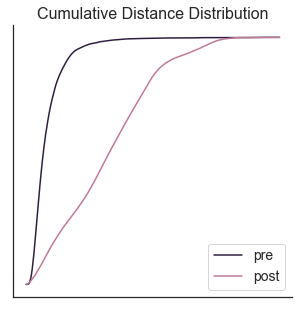

<Figure size 504x504 with 0 Axes>

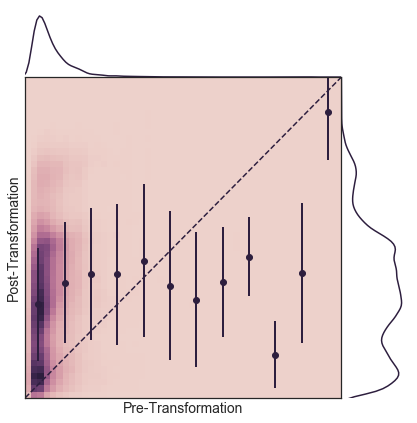

In [151]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_GLM-PCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/retina_GLM-PCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

In [152]:
colon_GLMPCA = DR.from_file('dev/Rmethods_out/colon_GLM-PCA.csv', name='GLM-PC', labels=[None,0])

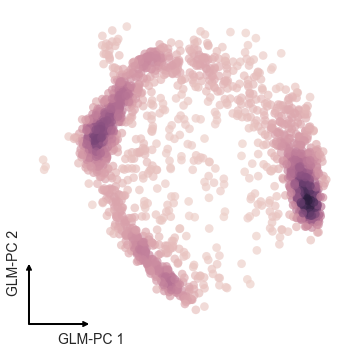

In [153]:
colon_GLMPCA.plot()

In [154]:
%%time 
pre_flat_norm, post_flat_norm, mantel_stats, EMD, KLD = distance_stats(pre=colon.distance_matrix(transform=None), post=colon_GLMPCA.distance_matrix())
knn = knn_preservation(pre=colon.knn_graph(k, transform=None), post=colon_GLMPCA.knn_graph(k))
print('R: {}\nEMD: {}\nKLD: {}\nKnn Pres.: {}'.format(round(mantel_stats[0],4), round(EMD,4), round(KLD,4), round(knn, 4)))

# dump outputs into dictionary
final_distance_stats['Colon']['R']['GLM-PCA'], final_distance_stats['Colon']['EMD']['GLM-PCA'], final_distance_stats['Colon']['KLD']['GLM-PCA'], final_distance_stats['Colon']['Knn Pres.']['GLM-PCA'] = mantel_stats[0], EMD, KLD, knn

R: 0.2429
EMD: 0.2783
KLD: 0.3345
Knn Pres.: 96.9369
CPU times: user 1min 9s, sys: 11.5 s, total: 1min 20s
Wall time: 1min 22s


CPU times: user 18.8 s, sys: 442 ms, total: 19.3 s
Wall time: 18.8 s


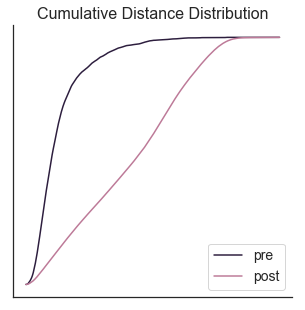

<Figure size 504x504 with 0 Axes>

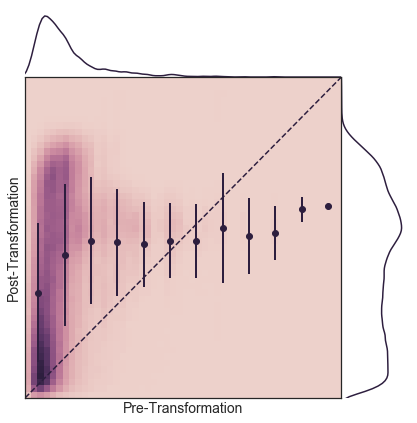

In [155]:
%%time
# output plots to file
plt.figure(figsize=(5,5))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_GLM-PCA_dist.png', transparent=True, bbox_inches='tight', dpi=1000)
plt.figure(figsize=(7,7))
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)
plt.savefig(fname='images/colon_GLM-PCA_corr.png', transparent=True, bbox_inches='tight', dpi=1000)

---
### Summary Metrics

In [156]:
retina_sum = pd.DataFrame(final_distance_stats['Retina'])

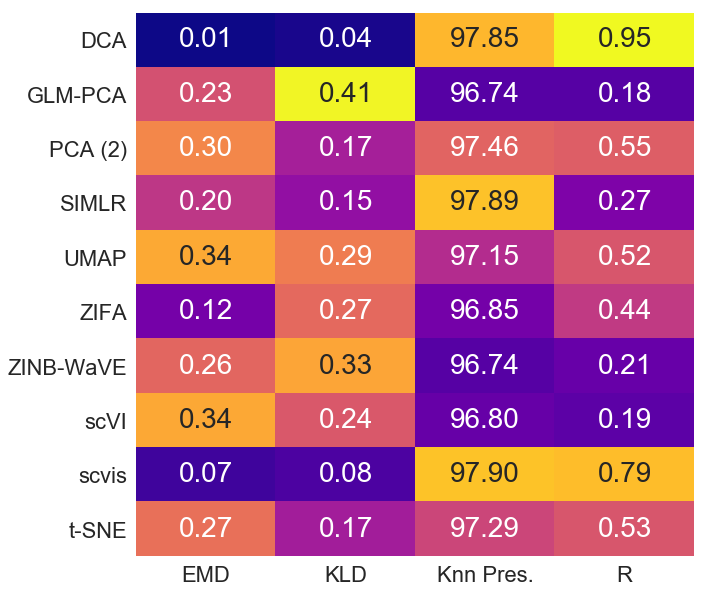

In [157]:
retina_norm=(retina_sum-retina_sum.mean())/retina_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
sns.heatmap(retina_norm, annot=retina_sum, cmap='plasma', robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)

In [158]:
colon_sum = pd.DataFrame(final_distance_stats['Colon'])

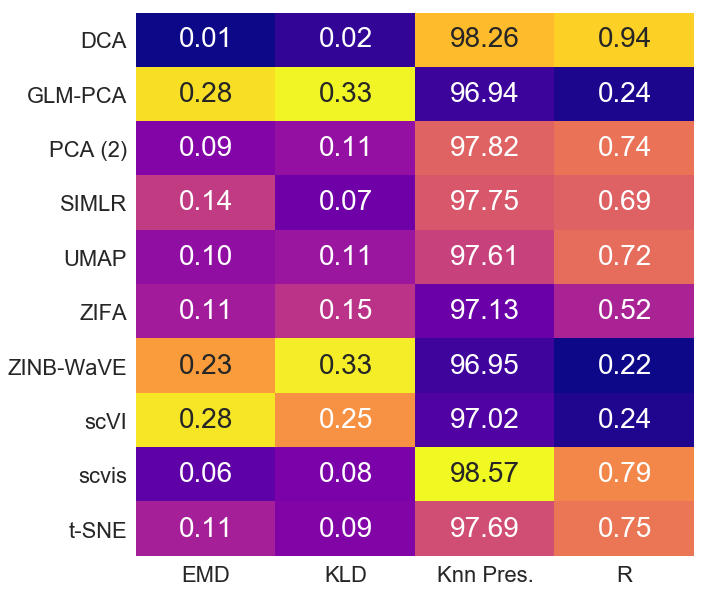

In [159]:
colon_norm=(colon_sum-colon_sum.mean())/colon_sum.std()
sns.set(font_scale=2)
plt.figure(figsize=(10,10))
sns.heatmap(colon_norm, annot=colon_sum, cmap='plasma', robust=True, annot_kws={"size": 28}, fmt='.2f', cbar=False)